### Removing Trend - log, cuberoot, sqrt and differencing, decomposition

In [22]:
import pandas as pd
import numpy as np
from statsmodels.tsa.stattools import adfuller
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.statespace.tools import diff

In [3]:
data = pd.read_csv('data/airline_passengers.csv', parse_dates=True, index_col='Month')
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 144 entries, 1949-01-01 to 1960-12-01
Data columns (total 1 columns):
 #   Column                   Non-Null Count  Dtype
---  ------                   --------------  -----
 0   Thousands of Passengers  144 non-null    int64
dtypes: int64(1)
memory usage: 2.2 KB


<AxesSubplot:xlabel='month'>

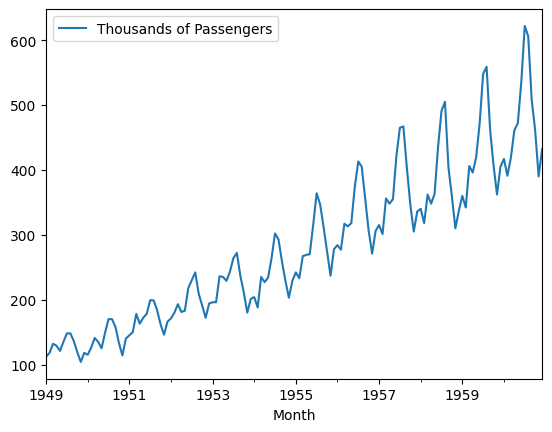

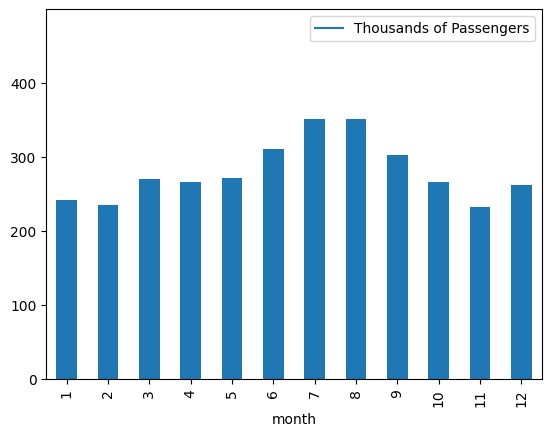

In [4]:
# plotting to check seasonality and trend
data.plot()

# rolling mean for every year 
data.rolling(12).mean().plot()

# group data monthly to see monthly trend
data['month']=data.index.month
data.groupby('month')['Thousands of Passengers'].mean().plot.bar()

In [8]:
# compare Test Statistic and Critical Values: should be in similar ranges
def adf_test(series,title=''):
    """
    Pass in a time series and an optional title, returns an ADF report
    """
    print(f'Augmented Dickey-Fuller Test: {title}')
    result = adfuller(series.dropna(),autolag='AIC') # .dropna() handles differenced data
    
    labels = ['ADF test statistic','p-value','# lags used','# observations']
    out = pd.Series(result[0:4],index=labels)

    for key,val in result[4].items():
        out[f'critical value ({key})']=val
        
    print(out.to_string())          # .to_string() removes the line "dtype: float64"
    
    if result[1] <= 0.05:
        print("Strong evidence against the null hypothesis")
        print("Reject the null hypothesis")
        print("Data has no unit root and is stationary")
    else:
        print("Weak evidence against the null hypothesis")
        print("Fail to reject the null hypothesis")
        print("Data has a unit root and is non-stationary")

In [9]:
adf_test(data['Thousands of Passengers'])

Augmented Dickey-Fuller Test: 
ADF test statistic        0.815369
p-value                   0.991880
# lags used              13.000000
# observations          130.000000
critical value (1%)      -3.481682
critical value (5%)      -2.884042
critical value (10%)     -2.578770
Weak evidence against the null hypothesis
Fail to reject the null hypothesis
Data has a unit root and is non-stationary


### ESTIMATING AND ELIMINATING TREND
could be done by taking log, square root, cube root
<br>here we should notice that smaller values has to be reduced lesser than larger values

<AxesSubplot:xlabel='Month'>

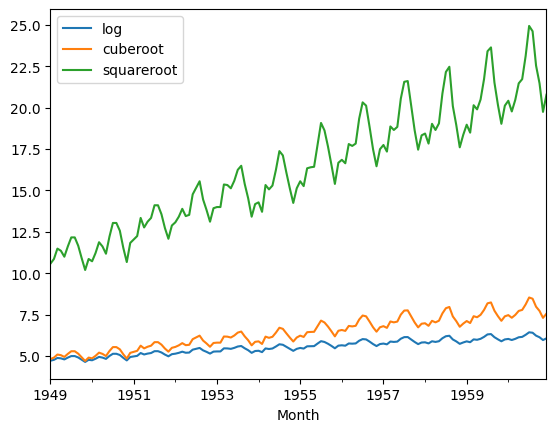

In [7]:
ts = pd.DataFrame()
ts['log'] = np.log(data['Thousands of Passengers'])
ts['log'].plot(legend=True)

ts['cuberoot'] = np.cbrt(data['Thousands of Passengers'])
ts['cuberoot'].plot(legend=True)

ts['squareroot'] = np.sqrt(data['Thousands of Passengers'])
ts['squareroot'].plot(legend=True)

# ts['diff'] = diff(data['Thousands of Passengers'], k_diff=1)
# ts['diff'].plot(legend=True)

Sometimes there is noise in the data and we are not able to see the trend clearly. Some techniques to remove this noise are:
1. Aggregation: taking average for a specific time period like weekly/monthly
2. Smoothing: taking rolling averages
3. Polynomical fitting: fit a regression model

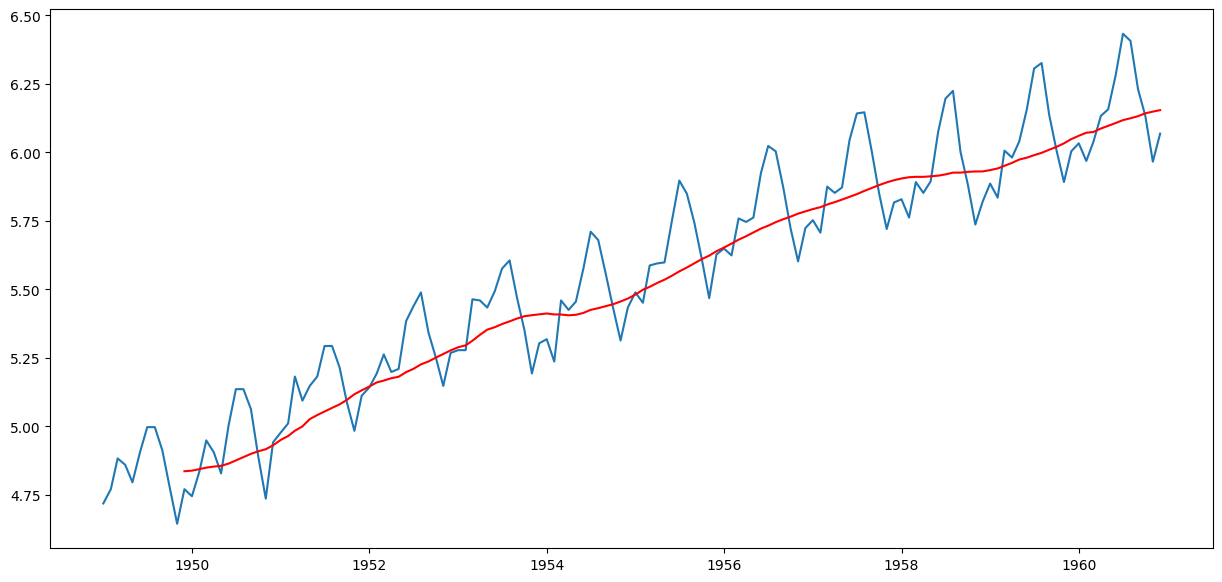

Augmented Dickey-Fuller Test: 
ADF test statistic       -3.162908
p-value                   0.022235
# lags used              13.000000
# observations          119.000000
critical value (1%)      -3.486535
critical value (5%)      -2.886151
critical value (10%)     -2.579896
Strong evidence against the null hypothesis
Reject the null hypothesis
Data has no unit root and is stationary


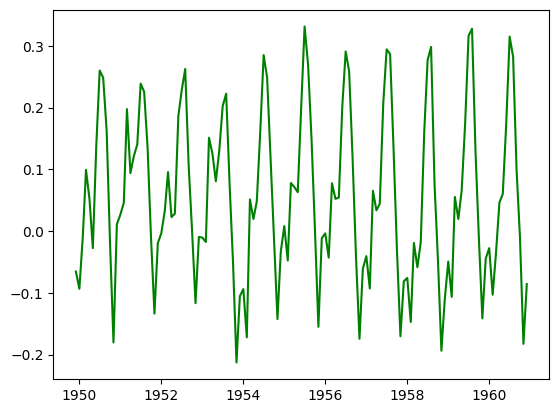

In [16]:
# 2) SMOOTHING
# a) using a specific time period
moving_avg = ts['log'].rolling(12).mean()
# since we are taking average over last 12 months and hence initial 11 values
# will not be defined here
plt.figure(figsize=(15,7))
plt.plot(ts['log'])
plt.plot(moving_avg, color='red')
plt.show()

# removing trend using first order differencing
ts_log_moving_avg_diff = ts['log'] - moving_avg
plt.plot(ts_log_moving_avg_diff, color='green')

# removing inital 11 values
ts_log_moving_avg_diff.dropna(inplace=True)
# test stationarity again
adf_test(ts_log_moving_avg_diff)
# here test statistic value is smaller than 10% and 5% and hence we can say
# that there is 95% confidance that series is stationary series


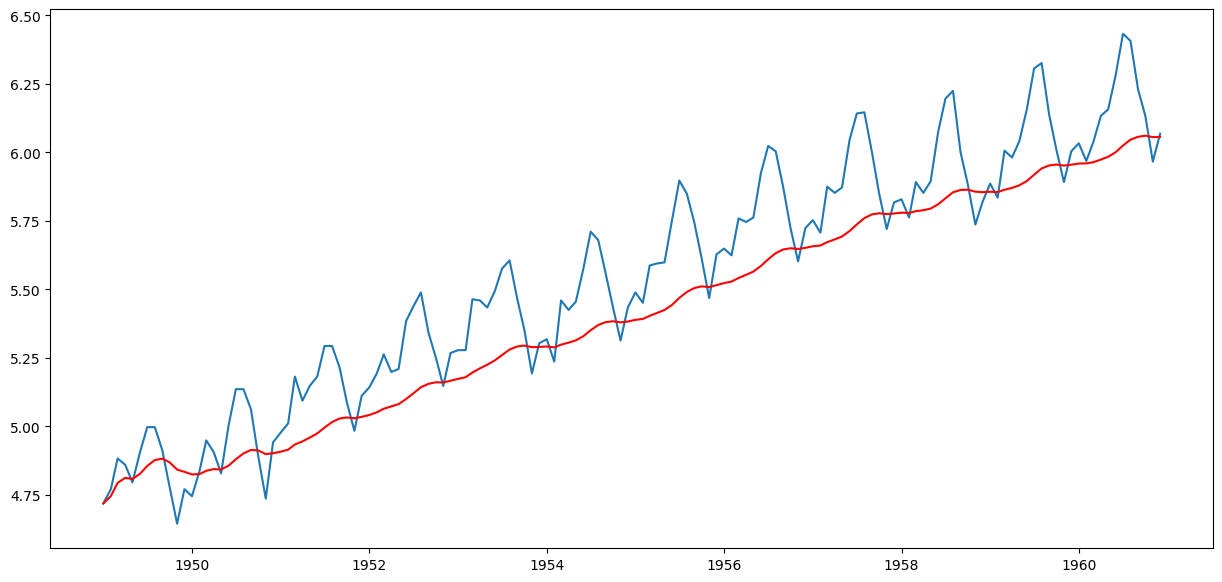

Augmented Dickey-Fuller Test: 
ADF test statistic       -3.601262
p-value                   0.005737
# lags used              13.000000
# observations          130.000000
critical value (1%)      -3.481682
critical value (5%)      -2.884042
critical value (10%)     -2.578770
Strong evidence against the null hypothesis
Reject the null hypothesis
Data has no unit root and is stationary


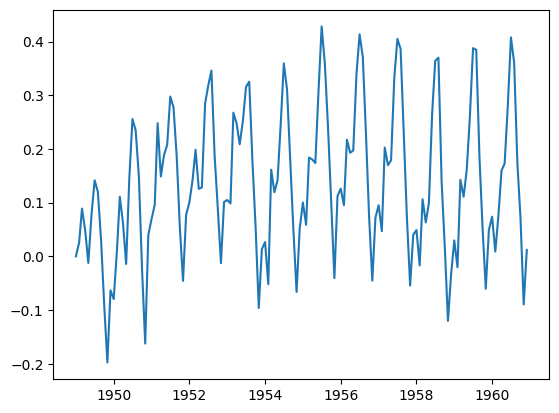

In [18]:
# b) taking weighted average when a period is hard to define like stock prices
# weighted moving average- recent values are given higher weight
# exponentially weighted moving average- you will see it in detail later
# http://pandas.pydata.org/pandas-docs/stable/computation.html#exponentially-weighted-moment-functions
expweighted_avg = ts['log'].ewm(halflife=12).mean()
plt.figure(figsize=(15,7))
plt.plot(ts['log'])
plt.plot(expweighted_avg, color='red')
plt.show()

# removing trend
ts_log_ewm_diff= ts['log'] - expweighted_avg
plt.plot(ts_log_ewm_diff)
adf_test(ts_log_ewm_diff)
# this is with 99% confidance as test statistics has values lower than 1% critical value

Trend and seasonlity aren't always eliminated this way, particularly data with high seasonality and hence we need to try other methods like-
1) Differencing- taking difference with particular time lag
2) Decomposition- modeling both trends and seasonality and removing them

# Differencing
## First Order Differencing
Non-stationary data can be made to look stationary through <em>differencing</em>. A simple method called <em>first order differencing</em> calculates the difference between consecutive observations.

&nbsp;&nbsp;&nbsp;&nbsp;$y^{\prime}_t = y_t - y_{t-1}$

In this way a linear trend is transformed into a horizontal set of values.


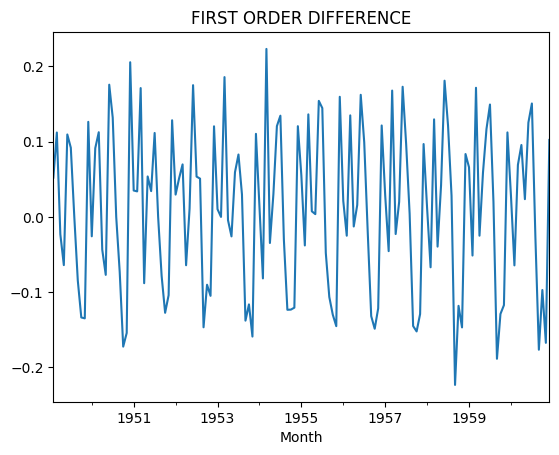

In [26]:
diff(ts['log'], k_diff=1).plot(title="FIRST ORDER DIFFERENCE");

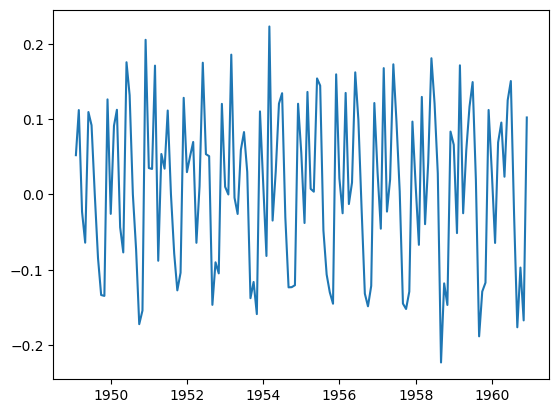

Augmented Dickey-Fuller Test: 
ADF test statistic       -2.717131
p-value                   0.071121
# lags used              14.000000
# observations          128.000000
critical value (1%)      -3.482501
critical value (5%)      -2.884398
critical value (10%)     -2.578960
Weak evidence against the null hypothesis
Fail to reject the null hypothesis
Data has a unit root and is non-stationary


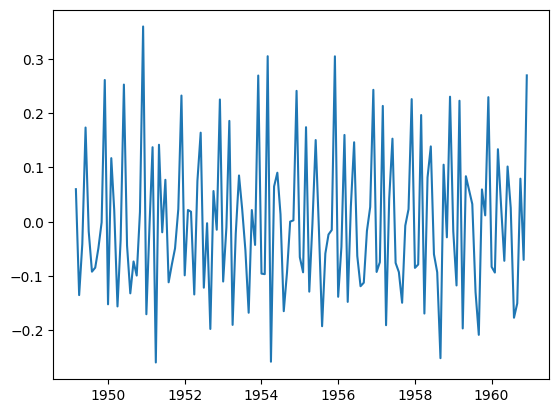

Augmented Dickey-Fuller Test: 
ADF test statistic     -8.196629e+00
p-value                 7.419305e-13
# lags used             1.300000e+01
# observations          1.280000e+02
critical value (1%)    -3.482501e+00
critical value (5%)    -2.884398e+00
critical value (10%)   -2.578960e+00
Strong evidence against the null hypothesis
Reject the null hypothesis
Data has no unit root and is stationary


In [21]:
# 1) Differencing
ts_log_diff = ts['log'] - ts['log'].shift()
ts_log_diff.dropna(inplace=True)
plt.plot(ts_log_diff)
plt.show()
adf_test(ts_log_diff)

ts_log_diff2 = ts_log_diff- ts_log_diff.shift()
ts_log_diff2.dropna(inplace=True)
plt.plot(ts_log_diff2)
plt.show()
adf_test(ts_log_diff2)

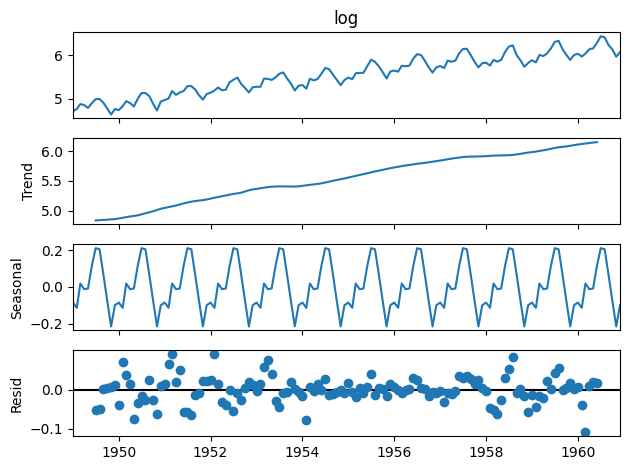

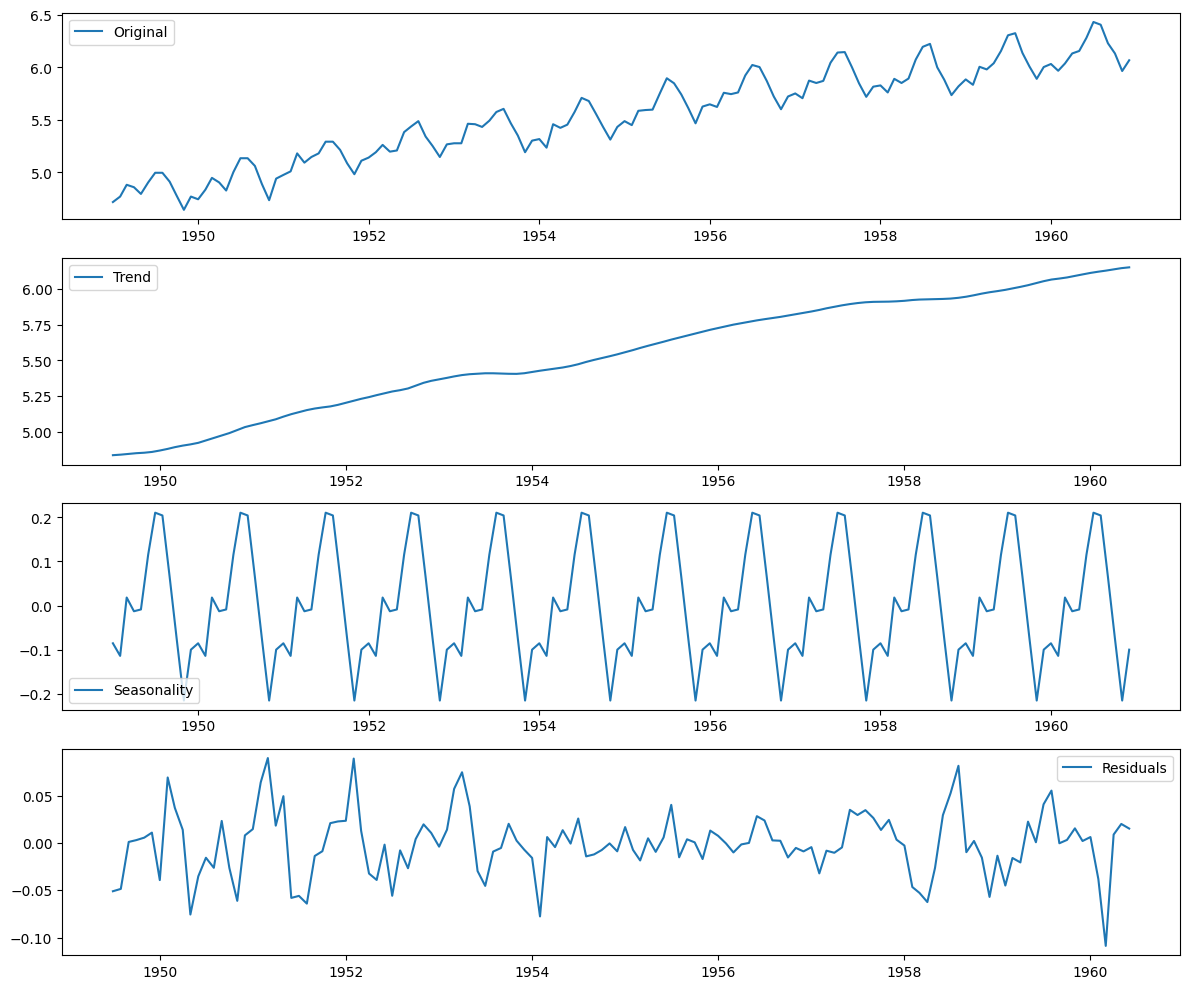

Augmented Dickey-Fuller Test: 
ADF test statistic     -6.332387e+00
p-value                 2.885059e-08
# lags used             9.000000e+00
# observations          1.220000e+02
critical value (1%)    -3.485122e+00
critical value (5%)    -2.885538e+00
critical value (10%)   -2.579569e+00
Strong evidence against the null hypothesis
Reject the null hypothesis
Data has no unit root and is stationary


In [28]:
# 2) Decomposing
decomposition = seasonal_decompose(ts['log'], model='additive')
# extract trend
trend = decomposition.trend
# extract seasonality
seasonal = decomposition.seasonal
# extract residual
residual = decomposition.resid

# method 1
result = decomposition.plot()

# method 2
plt.figure(figsize=(12,10))
plt.subplot(411)
plt.plot(ts['log'], label='Original')
plt.legend(loc='best')
plt.subplot(412)
plt.plot(trend, label='Trend')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(seasonal,label='Seasonality')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(residual, label='Residuals')
plt.legend(loc='best')
plt.tight_layout()
plt.show()

# lets check stationarity of residual
ts_log_decompose = residual
ts_log_decompose.dropna(inplace=True)
adf_test(ts_log_decompose)

Series is stationary with 99% confidence

## Another Dataset

In [4]:
# read data
df = pd.read_csv("data/multiTimeline.csv", skiprows=2, parse_dates=True, index_col='Month') 
# check data info
print(df.info())

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 168 entries, 2004-01-01 to 2017-12-01
Data columns (total 3 columns):
 #   Column                Non-Null Count  Dtype
---  ------                --------------  -----
 0   diet: (Worldwide)     168 non-null    int64
 1   gym: (Worldwide)      168 non-null    int64
 2   finance: (Worldwide)  168 non-null    int64
dtypes: int64(3)
memory usage: 5.2 KB
None


Text(0.5, 0, 'Year')

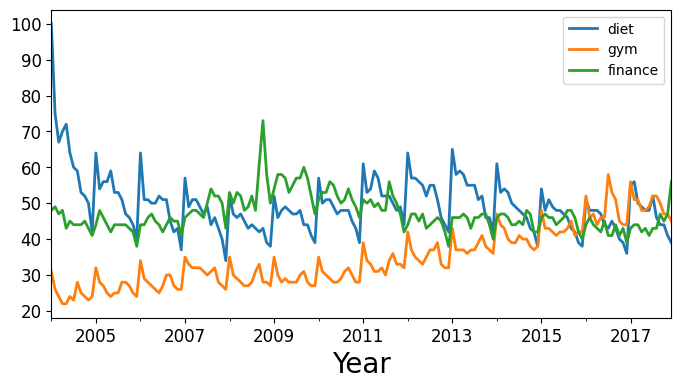

In [13]:
# rename columns to remove white spaces
df.columns = ['diet', 'gym', 'finance']

# plot data
df.plot(figsize=(8,4), linewidth=2, fontsize=12)
plt.xlabel('Year', fontsize=20)

Numbers represent search interest relative to the highest point on the chart
 for the given region and time. A value of 100 is the peak popularity for the 
 term. A value of 50 means that the term is half as popular. Likewise a score 
 of 0 means the term was less than 1% as popular as the peak.

Text(0.5, 0, 'Year')

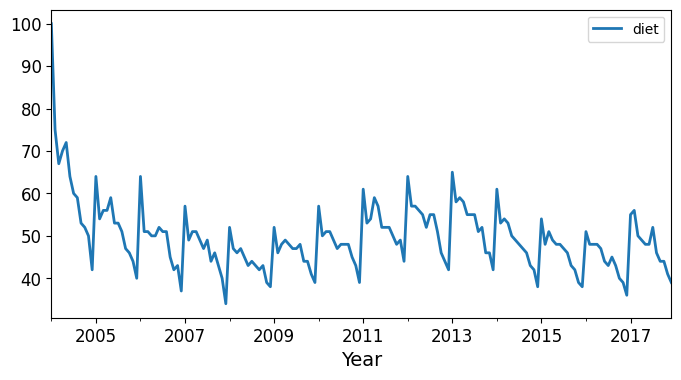

In [12]:
# plot diet
df[['diet']].plot(figsize=(8,4), linewidth=2, fontsize=12)
plt.xlabel('Year', fontsize=14)

the first thing to notice is that there is seasonality: each January, 
there's a big jump. Also, there seems to be a trend: it seems to go slightly 
up, then down, back up and then back down. In other words, it looks like 
there are trends and seasonal components to these time series.

In [14]:
diet = df[['diet']]
gym = df[['gym']]
finance = df[['finance']]

Text(0.5, 0, 'Year')

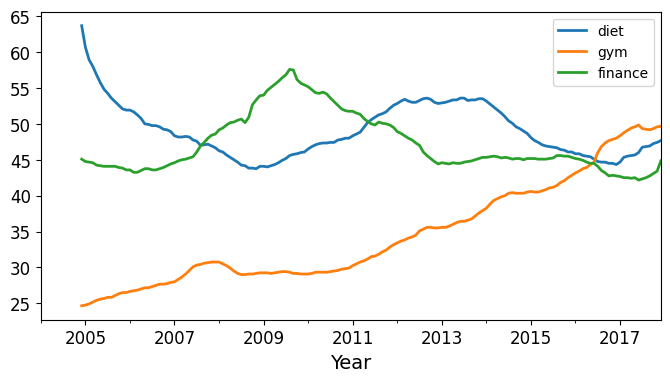

In [19]:
# comparing trends
df_rm = pd.concat([diet.rolling(12).mean(), gym.rolling(12).mean(), finance.rolling(12).mean()], axis=1)
df_rm.plot(figsize=(8,4), linewidth=2, fontsize=12)
plt.xlabel('Year', fontsize=14)

here it is clear that gym has a trend of continuous increase

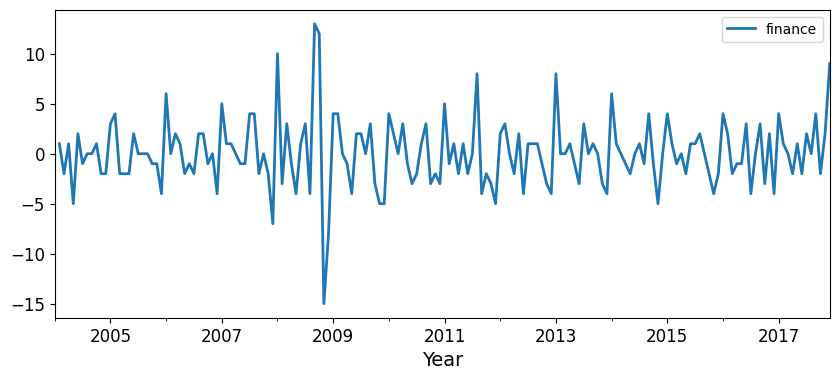

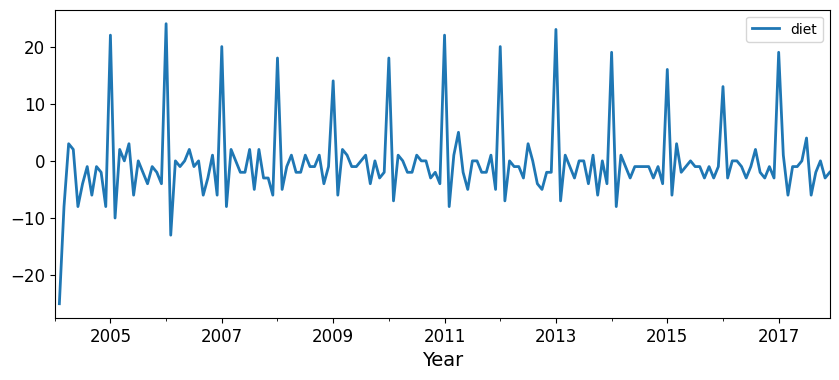

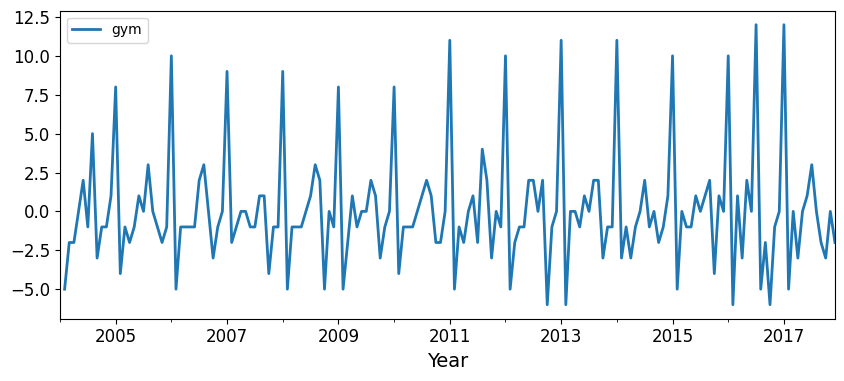

In [25]:
# removing trend using first order differencing
finance.diff().plot(figsize=(10,4), linewidth=2, fontsize=12)
plt.xlabel('Year', fontsize=14)
plt.show()

diet.diff().plot(figsize=(10,4), linewidth=2, fontsize=12)
plt.xlabel('Year', fontsize=14)
plt.show()

gym.diff().plot(figsize=(10,4), linewidth=2, fontsize=12)
plt.xlabel('Year', fontsize=14)
plt.show()

In [26]:
# checking correlation with trend and seasonality if present
df.corr()

,diet,gym,finance
diet,1.000000,-0.100764,-0.034639
gym,-0.100764,1.000000,-0.284279
finance,-0.034639,-0.284279,1.000000


In [28]:
# check correlation after removing trend
df.diff().corr()

,diet,gym,finance
diet,1.000000,0.758707,0.373828
gym,0.758707,1.000000,0.301111
finance,0.373828,0.301111,1.000000


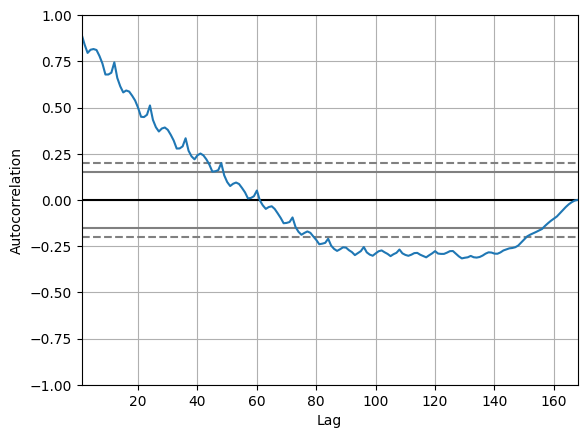

In [32]:
pd.plotting.autocorrelation_plot(gym);

checking autocorrelation i.e. whether the series is repeating itself after
a particular duration or not.